# XGBoost examples

## 1. Scikit-Learn API, Missing Values
- [XGBoost FAQ: How to deal with missing values](https://xgboost.readthedocs.io/en/latest/faq.html?highlight=missing#how-to-deal-with-missing-value)
- [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) (`XGBRegressor` and `XGBClassifier`)

In this example, we load Titanic data and encode categoricals as ordinals, but do _not_ impute missing values:

In [1]:
import category_encoders as ce
import pandas as pd
import seaborn as sns

titanic = sns.load_dataset('titanic')
X = titanic[['age', 'class', 'deck', 'embarked', 'fare', 'sex']]
y = titanic['survived']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       714 non-null    float64 
 1   class     891 non-null    category
 2   deck      203 non-null    category
 3   embarked  889 non-null    object  
 4   fare      891 non-null    float64 
 5   sex       891 non-null    object  
dtypes: category(2), float64(2), object(2)
memory usage: 30.2+ KB


In [12]:
# handle_unknown='ignore' treats unkwon as another category
encoder = ce.OrdinalEncoder(handle_unknown='ignore', 
                            cols=['class', 'deck', 'embarked', 'sex'])
X_transformed = encoder.fit_transform(X)
X_transformed.sample(10)

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,age,class,deck,embarked,fare,sex
363,35.00,1,1,1,7.0500,1
755,0.67,3,1,1,14.5000,1
377,27.00,2,2,2,211.5000,1
851,74.00,1,1,1,7.7750,1
232,59.00,3,1,1,13.5000,1
12,20.00,1,1,1,8.0500,1
736,48.00,1,1,1,34.3750,2
743,24.00,1,1,1,16.1000,1
73,26.00,1,1,2,14.4542,1
715,19.00,1,8,1,7.6500,1


In [11]:
print(X_transformed["embarked"].value_counts(dropna=False))
print(X["embarked"].value_counts(dropna=False))


1    644
2    168
3     77
4      2
Name: embarked, dtype: int64
S      644
C      168
Q       77
NaN      2
Name: embarked, dtype: int64


In [4]:
X_transformed.isnull().sum()

age         177
class         0
deck          0
embarked      0
fare          0
sex           0
dtype: int64

`XGBClassifier` can be used like a scikit-learn estimator, but it works with missing values!
Instead of train, validation split we use `cross_val_score`

In [13]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model = XGBClassifier()
cross_val_score(model, X_transformed, y, 
                scoring='accuracy', cv=5, n_jobs=-1)

array([0.79329609, 0.81460674, 0.86516854, 0.78089888, 0.8258427 ])

## 2. Learning API, early stopping, monotonic constraints

### Monotonic constraints

_From [**Ideas on interpreting machine learning**](https://www.oreilly.com/ideas/ideas-on-interpreting-machine-learning) by Patrick Hall, Wen Phan, and SriSatish Ambati_

![](https://d3ansictanv2wj.cloudfront.net/figure_13-5c27095f0fc9ea57132fa54fd88f0fee.jpg)

> **Monotonicity is often expected by regulators:** no matter what a training data sample says, regulators may still want to see monotonic behavior. Consider savings account balances in credit scoring. A high savings account balance should be an indication of creditworthiness, whereas a low savings account balance should be an indicator of potential default risk. If a certain batch of training data contains many examples of individuals with high savings account balances defaulting on loans or individuals with low savings account balances paying off loans, of course a machine-learned response function trained on this data would be non-monotonic with respect to savings account balance. This type of predictive function could be unsatisfactory to regulators because it defies decades of accumulated domain expertise and thus decreases trust in the model or sample data.


> **Monotonicity enables consistent reason code generation:** consistent reason code generation is generally considered a gold standard of model interpretability. If monotonicity is guaranteed by a credit scoring model, reasoning about credit applications is straightforward and automatic. If someone's savings account balance is low, their credit worthiness is also low. Once monotonicity is assured, reasons for credit decisions can then be reliably ranked...

### More about monotonic constraints and interpretability
- [XGBoost Tutorials — Monotonic Constraints](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html)
- [A Tutorial of Model Monotonicity Constraint Using Xgboost](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
- [Monotonicity constraints in LightGBM](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)
- [TensorFlow Lattice](https://github.com/tensorflow/lattice): "an implementation of Monotonic Calibrated Interpolated Look-Up Tables in TensorFlow."
- [A curated list of awesome machine learning interpretability resources](https://github.com/jphall663/awesome-machine-learning-interpretability)

***This example is adapted from [A Tutorial of Model Monotonicity Constraint Using Xgboost](https://xiaoxiaowang87.github.io/monotonicity_constraint/)***

>  For a tree-based model, if for each split of a particular variable we require the right daughter node’s average value to be higher than the left daughter node (otherwise the split will not be made), then approximately this predictor’s relationship with the dependent variable is monotonically increasing; and vise versa.

> I’m going to use the California Housing dataset for this tutorial. This dataset consists of 20,460 observations. Each observation represents a neighborhood in California. The response variable is the median house value of a neighborhood. Predictors include median income, average house occupancy, and location etc. of that neighborhood.

In [14]:
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.model_selection import train_test_split

california_housing = fetch_california_housing()
columns = ['Median Income', 'House Age', 'Average Rooms', 
           'Average Bedrooms', 'Population', 'Average Occupancy', 
           'Latitude', 'Longitude']

X = pd.DataFrame(california_housing.data, columns=columns)
X['Median Income'] = X['Median Income'] * 10000
y = pd.Series(california_housing.target * 100000, 
              name='Median House Value')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=123)

print(california_housing.DESCR)

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.california_housing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

> To start, we use a single feature “the median income” to predict the house value.  We first split the data into training and testing datasets. Then We use a 5-fold cross-validation and early-stopping on the training dataset to determine the best number of trees. Last, we use the entire training set to train my model and evaluate its performance on the testset.

> Notice the model parameter `'monotone_constraints'`. This is where the monotonicity constraints are set in Xgboost. For now I set `'monotone_constraints': '(0)'`, which means a single feature without constraint.

[XGBoost Data Interface](https://xgboost.readthedocs.io/en/latest/python/python_intro.html#data-interface)

The data is stored in a DMatrix object. Please be careful that, XGBoost does not understand file extensions, nor try to guess the file format, as there is no universal agreement upon file extension of LibSVM or CSV. Instead it employs URI format for specifying the precise input file type. For example if you provide a csv file ./data.train.csv as input, XGBoost will blindly use the default libsvm parser to digest it and generate a parser error. Instead, users need to provide an uri in the form of train.csv?format=csv.

In [15]:
import xgboost as xgb

features = ['Median Income']
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

- [Enforcing Monotonic Constraints in XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html#enforcing-monotonic-constraints-in-xgboost)
- [XGBoost Tutorials: Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
- [XGBoost Python API Reference: Learning API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)
- [xgboost.cv](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.cv) parameters
  - params (dict) – Booster params.
  - dtrain (DMatrix) – Data to be trained.
  - num_boost_round (int) – Number of boosting iterations.
  - nfold (int) – Number of folds in CV.
  - early_stopping_rounds (int) – Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue. Last entry in evaluation history is the one from best iteration.
  - as_pandas (bool, default True) – Return pd.DataFrame when pandas is installed. If False or pandas is not installed, return np.ndarray

In [20]:
params = {'monotone_constraints': '(0)', # no constraint
          'max_depth': 2,
          'eta': 0.1,
          'silent': 1, 
          'n_jobs': -1,
          'seed': 0,
          'eval_metric': 'rmse'}

# Cross validation Without early stopping
bst_cv = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, 
                early_stopping_rounds=None, as_pandas=True)

[07:07:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:07:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:07:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

**There are 1000 boost rounds and the rmse does not decrease in every round**

In [25]:
bst_cv.tail(6), bst_cv.shape, X_train.shape

(     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
 994     77087.709375      402.556287    83257.998438    1450.431493
 995     77085.585937      402.503384    83257.421875    1451.554773
 996     77082.289063      401.625791    83258.690625    1452.295136
 997     77080.204687      401.349476    83259.354687    1452.372700
 998     77077.251563      400.828846    83258.834375    1452.818492
 999     77073.831250      400.292904    83260.523437    1450.590585,
 (1000, 4),
 (12384, 8))

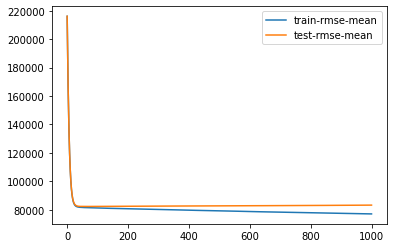

In [26]:
bst_cv[['train-rmse-mean', 'test-rmse-mean']].plot();

In [27]:
# With early stopping. Use CV to find the best number of trees
bst_cv = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, 
                early_stopping_rounds=10, as_pandas=True)

[07:14:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:14:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:14:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

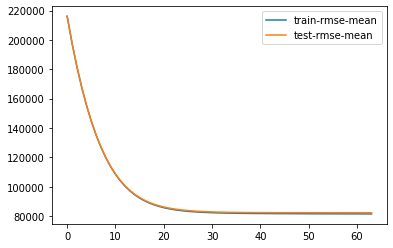

In [28]:
bst_cv[['train-rmse-mean', 'test-rmse-mean']].plot();

x-axis is number of boost rounds. We can get an approximation of best number of rounds. The best number of rounds is scaled up as an approximation of the best round if after the CV we want to use the entire data to re-train the model.

In [31]:
n_folds = 5
estop = 10
best_nrounds = int((bst_cv.shape[0] - estop) / (1 - 1 / n_folds))
best_nrounds

67

*Let's train the xgb with the given parameters and the entire train data. Then we'll evaluate the rmse based on the test data*

In [35]:
bst = xgb.train(params, dtrain, num_boost_round=67)
print(bst.eval(dtest))

[08:47:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:82875.601562


In [36]:
bst.best_ntree_limit

67

> We can also check the relationship between the feature (median income) and the dependent variable (median house value)

**Bad News:** [PDPbox](https://github.com/SauceCat/PDPbox) works with scikit-learn, but not xgboost :-(

**Good News:** [The tutorial](https://xiaoxiaowang87.github.io/monotonicity_constraint/) has a custom partial dependency function. We can adapt it and get a better understanding [how partial dependence plots work](https://twitter.com/ChristophMolnar/status/1066398522608635904)!

> Here I wrote a helper function partial_dependency to calculate the variable dependency or partial dependency for an arbitrary model. The partial dependency describes that when other variables fixed, how the average response depends on a predictor.

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def partial_dependency(bst, X, y, feature):
    """
    Calculate the dependency (or partial dependency) of a response 
    variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with 
    this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    grid = np.linspace(start=np.percentile(X_temp[feature], 0.1),
                       stop=np.percentile(X_temp[feature], 99.5),
                       num=50)
    
    y_pred = np.zeros(len(grid))

    for i, value in enumerate(grid):
        """
        We use the same value of one feature in all the observations, where other
        feature values change from one observation to another. The predicted value
        for that feature value would be the average of all the predictions for that
        value with different values of all other features.
        """
        X_temp[feature] = value
        data = xgb.DMatrix(X_temp)
        # ntree_limit: Limit number of trees in the prediction; defaults to 0 (use all trees).
        ipred = bst.predict(data, ntree_limit=bst.best_ntree_limit)
        # all the ipred values are the same
        y_pred[i] = np.average(ipred)
    
    print(f"ipred.shape is: {ipred.shape}, \none row of ipred is:\n{ipred}")
    plt.plot(grid, y_pred, '-', color='red', linewidth=2.5)
    plt.plot(X, y, 'o', color='grey', alpha=0.01)
    plt.xlim(min(grid), max(grid))
    plt.xlabel(feature)
    plt.ylabel(y.name)
    plt.show()


In [56]:
print(X_train.shape)
params

(12384, 8)


{'monotone_constraints': '(0)',
 'max_depth': 2,
 'eta': 0.1,
 'silent': 0,
 'n_jobs': -1,
 'seed': 0,
 'eval_metric': 'rmse'}

> Without any monotonicity constraint, the relationship between the median income and median house value looks like this:

ipred.shape is: (12384,), 
one row of ipred is:
[481078.7 481078.7 481078.7 ... 481078.7 481078.7 481078.7]


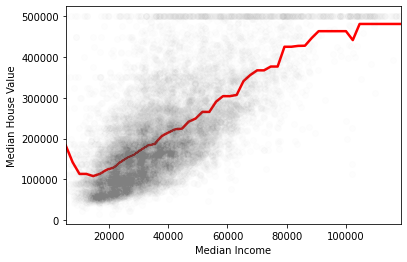

In [57]:
partial_dependency(bst, X_train[features], y_train, 
                   feature='Median Income')

> One can see that at very low income and income around 10 (times its unit), the relationship between median income and median house value is not strictly monotonic.

> You may be able to find some explanations for this non-monotonic behavior (e.g. feature interactions). In some cases, it may even be a real effect which still holds true after more features are fitted. If you are very convinced about that, I suggest you not enforce any monotonic constraint on the variable, otherwise important relationships may be ignored. **But when the non-monotonic behavior is purely because of noise, setting monotonic constraints can reduce overfitting.**

> For this example, it is hard to justify that neighborhoods with a low median income have a high median house value. Therefore we will try enforcing the monotonicity on the median income:

In [60]:
params['monotone_constraints'] = '(1)'

> We then ... refit the model and evaluate it on the testset. Below is the result:

In [61]:
bst = xgb.train(params, dtrain, num_boost_round=60)
print(bst.eval(dtest))

[16:25:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:82792.953125


It's happened to have a lower evaluation error compared to no monotonicity here.

> We may have reduced overfitting and improved our performance on the testset. **However, given that statistical uncertainties on these numbers are probably just as big as the differences, it is just a hypothesis. For this example, the bottom line is that adding monotonicity constraint does not significantly hurt the performance.**

> Now we can check the variable dependency again:

ipred.shape is: (12384,), 
one row of ipred is:
[484284.06 484284.06 484284.06 ... 484284.06 484284.06 484284.06]


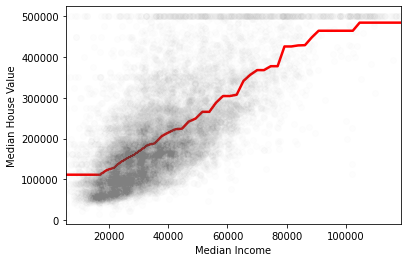

In [62]:
partial_dependency(bst, X_train[features], y_train, 
                   feature='Median Income')

> Great! Now the response is monotonically increasing with the predictor. This model has also become a bit easier to explain.

> We can also enforce monotonicity constraints while fitting multiple features. For example:

[18:03:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:70115.718750
ipred.shape is: (12384,), 
one row of ipred is:
[457791.97 444613.34 465965.66 ... 420086.78 558697.7  425555.1 ]


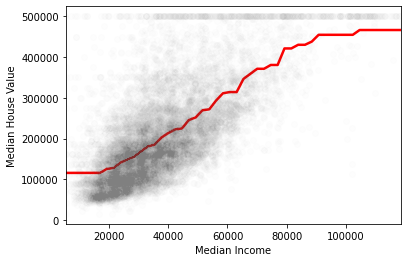

ipred.shape is: (12384,), 
one row of ipred is:
[219466.8   242368.31  250735.34  ... 239689.58  188932.06  121881.305]


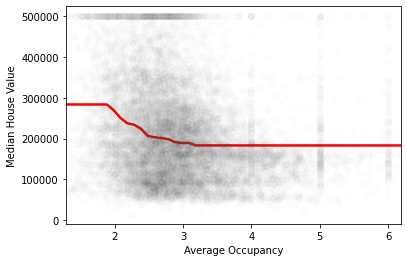

ipred.shape is: (12384,), 
one row of ipred is:
[270439.88 275491.06 288603.3  ... 297829.4  350946.22 149275.92]


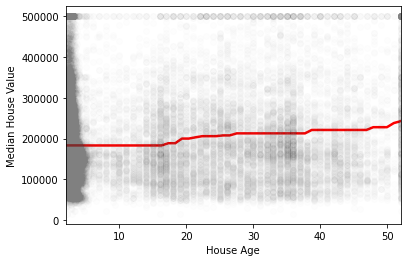

In [63]:
features = ['Median Income', 'Average Occupancy', 'House Age']
params['monotone_constraints'] = '(1, -1, 1)'

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

bst = xgb.train(params, dtrain, num_boost_round=60)
print(bst.eval(dtest))

for feature in features:
    partial_dependency(bst, X_train[features], y_train, feature=feature)

*The gray o datapoints are the same as training data set, plotted for y vs every feature in the dataset. Those plots by themselves do not give any visibility on how a particular feature is related to the target y. By averaging all the predictions for any given value of a particular feature over the entire training set comprised of all other features, we'll get an aggregated value for each value of a particular feature.*

> We assume that median house value is positively correlated with median income and house age, but negatively correlated with average house occupancy.

> Is it a good idea to enforce monotonicity constraints on features? It depends. For the example here, I didn’t see a significant performance decrease, and I think the directions of these variables make intuitive sense. For other cases, especially when the number of variables is large, it may be difficult and even dangerous to do so. It certainly relies on a lot of domain expertise and exploratory analysis to fit a model that is “as simple as possible, but no simpler”.